Contenido bajo licencia Creative Commons BY 4.0 y código bajo licencia MIT. © Juan Gómez y Nicolas Guarín-Zapata 2019. Este material es parte del curso Mecánica de los Medios Continuos en el programa de Ingeniería Civil de la Universidad EAFIT.

# Diseño de una presa trapezoidal de concreto.

**Nota:** Para poder utilizar el notebook es necesario tener instalado SolidsPy y los modulos requeridos (ver la documentación de [SolidsPy](https://solidspy.readthedocs.io/en/latest/readme.html)). Adicionalmente se requieren varios archivos correspondientes al modelo de la presa.*

Para entender de manera rapida como crear y analizar un modelo de elementos finitos con SolidsPy se recomienda seguir los NBs 03 y 04 disponibles en el repositorio.

## Introducción

El presente NoteBook (NB) describe un problema de ingeniería civil cuya solución requiere, además del uso de herramientas de simulación numérica, la aplicación de conceptos fundamentales de la materia **Mecánia de los Medios Continuos**. El proyecto se enmarca en la modalidad de **Aprendizaje Basado en Proyectos** dentro de la cual se expone a los estudiantes a un problema típico de ingeniería, posiblemente sin solución única y en algunas ocasiones mal formulado.

El tema partícular del presente proyecto corresponde al diseño de una presa de concreto bajo ciertas restricciones impuestas por las resistencias de los materiales. Como diseño inicial se plantea una presa de forma trapezoidal y para desarrollar el análisis se usa la herramienta por elementos finitos [SolidsPy](https://solidspy.readthedocs.io/en/latest/readme.html). El mayor puntaje lo recibirá la propuesta que obtenga la mayor relación beneficio/costo y que se encuentre acompañada de la mejor justificación física y metodologica.

En este NB inicialmente se define el problema en términos de parámetros de materiales, costos de los materiales, capacidad de generación de energía, etc. Posteriromente se describen varias subrutinas que pueden ser útiles para la solución del problema, aunque en general se espera que los equipos de trabajo desarrollen rutinas adicionales de acuerdo a las necesidades del método de análisis. Posteriormente se describen las rutinas de procesado de mallas y de generación de cargas y en la parte final se muestran los pasos mínimos de un análisis por elementos finitos para un caso partícuar.

## Aspectos a considerar

<div class="alert alert-warning">
    
En la calificación de los proyectos se tendrán en cuenta los siguientes aspectos:



1. Organización, claridad y documentación del Notebook (5%).
2. Discusión relativa a la verificación del modelo numérico (5%).
3. Calidad de la solución en términos de la relación beneficio/costo. (40%).
4. Método de solución usado para llegar al diseño óptimo (50%).





</div>


## Verificación

<div class="alert alert-warning">
    
A manera de verificación del software se recomienda abordar un problema con solución análitica conocida. Se propone el caso de una presa triangular con ángulo interno de $45 ^ {\circ}$ disponible en el NB 02 de este repo. Durante la verificación tenga en cuenta las condiciones de la solución análitica y las posibles limitaciones del software. Escriba un par de párrafos discutiendo los resultados del ejercicio de verificación.

</div>



## Definición del problema.

Para atender las demandas de energía de un país se requiere diseñar una presa de concreto de forma trapezoidal (ver figura). Considerando el caudal disponible en la fuente hidrica, la presa puede tener una altura superior a los $100$ $m$ por lo que se requiere diseñar la misma de manera que ofrezca la mayor relación beneficio/costo. Esta relación se define como

$$
R=\frac {E_w}C
$$

donde $E_w$ es la cantidad de energía producida (medidad en Mega vatios) y $C$ es el costo total (en dolares).

En este sentido, el mejor diseño será aquel que genere la mayor cantidad de energía, con el menor volumen de concreto y por ende con el menor costo.

Para el diseño de la presa se deben tener en cuenta las siguientes condiciones.

* Por cada 10 m de altura se podrán generar 100 MW de energía.

* El metro cúbico de concreto del tipo asumido como material base tiene un costo de 1000 USD. Para calcular el volumen de concreto use $V_c = A_s*1.0$ donde $A_s$ es el área superficial de la presa.

* Cada megapascal de aumento en la resistencia a la compresión del concreto tiene un costo de 100 USD.

* Cada megapascal de aumento en la resistencia a la tensión del concreto tiene un costo de 500 USD.

* Cada megapascal de aumento en la resistencia al corte del concreto tiene un costo de 300 USD.

El material base para el concreto de la presa tiene las siguientes propiedades:

* Módulo de elasticidad: 50 GPa.

* Relación de Poisson: 0.20.

* Resistencia a la compresión: 60 MPa.

* Resistencia a la tensión: 10 MPa.

* Resistencia al corte : 15 MPa.

La presa se construirá sobre un basamento  rocoso (basalto asumido elástico y de extensión infinita) con las siguientes propiedades:

* Módulo de elasticidad: 60 GPa.

* Relación de Poisson: 0.20.

Se asume además que:

* La presa estará sometida a la acción de la presión hidrostática impartida por un fluido de peso especifico $\gamma = 9.8 \text{ kN/m}^3$ y dada por:

$$
p = \gamma z
$$

donde  $z$ es la distancia desde la superficie libre del fluido asumida en la misma cota de la cresta de la presa.

* El programa de análisis asume condiciones de deformación plana.

* Es posible considerar las fuerzas de cuerpo correspondientes al peso propio de la presa.

<center><img src="img/dam.png" alt="files" style="width:500px"></center>

**(Para facilitar las simulaciones al final del notebook se describe el mapa de lineas del modelo de gmsh)**

### Dimensiones del modelo

Las dimensiones del modelo son las siguientes:

* $H_p $ : es la altura de la presa .

* $A_p$ : es el ancho de la pata.

* $A_c$ : es el ancho de la cresta.

Los paramétros para el rectangulo que representa el suelo no se consideran paramétros de diseño, pero sus valores pueden afectar la precisión de los resultados. Estos se definen como:

* $H_s$ : profundidad del deposito de suelo.

* $D_l$ : distancia de la frontera izquierda medida desde la pata de la presa.

* $D_r$ : distancia de la fronetra derecha medida desde la pata de la presa.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import meshio
import solidspy.preprocesor as msh
import solidspy.assemutil as ass
import solidspy.postprocesor as pos
import solidspy.solutil as sol

## 1) Subrutinas útiles para el análisis

A continuación se incluyen varias subrutinas que pueden resultar útiles en la revisión de un diseño en particular.

### Filtrado de resultados

La primer rutina, denominada `filtered()`, permite filtrar todos los valores de un campo solución que se encuentren por debajo de cierto valor límite del campo especificado en el parámetro `threshold`. Esta rutina es útil a la hora de verificar si una solución sobrepasa las resistencias de los materiales.

In [2]:
def filtered(nodes, elements, field, threshold, fig=None):
    """Plot contours for values higher than threshold"""
    if fig is None:
        plt.figure()
    plt.triplot(nodes[:, 1], nodes[:, 2], elements[:, 3:], zorder=3,
                color="#757575")
    if threshold < 0.0 and threshold > field.min():
        plt.tricontourf(nodes[:, 1], nodes[:, 2], elements[:, 3:], field,
                        levels=[field.min(), threshold], zorder=4, cmap="PuRd")
    if threshold > 0.0 and threshold < field.max():
        plt.tricontourf(nodes[:, 1], nodes[:, 2], elements[:, 3:], field,
                        levels=[threshold, field.max()], zorder=4, cmap="PuRd")
    plt.axis("image")
    return None

### Energía de deformación

La subrutina `energy()`, permite calcular la energía de deformación del sistema definida como:

$$
\Pi=\frac12\sigma^T\varepsilon.
$$



In [3]:
def energy(E_nodes, S_nodes):
    """Compute deformation energy density for the model"""
    small_pi = 0.5 * np.sum(S_nodes * E_nodes, axis=1)
    return small_pi

### Calculo de fuerzas

La rutina `res_forces()` permite calcular el vector:

$$
\left\{F_G\right\}=\left[K_G\right]\left\{U_G\right\}
$$

para un conjunto de nudos pertenecientes a una linea física. Esta rutina puede ser usada para verificar condiciones de equilibrio.

In [4]:
def res_forces(KG, UG, IBC, neq, nodes, phy_lin):
    """
    Encuentra las fuerzas nodales a lo largo de la linea fisica
    phy_lin usando el producto de F= KG*UG
    Parameters
    ----------
    KG: array
        Array storing the glopbal stiffness matrix of the system
    physical_line : int
        Physical line identifier.
    nodes : array
        Array with the coordinates of the mesh.
    Returns
    -------
    dof_id : list
            Lista identificando los grados de libertad asociados con las fuerza.
    react_group: array
         Arreglo con las fuerzas sobre la linea fisica.

    """
    nnodes = nodes.shape[0]
    F = np.zeros((neq))
    nodes_id, line_x, line_y = locate_pts_line(phy_lin, nodes)
    true_nodes_id = IBC[nodes_id]
    F = KG.dot(UG)
    dof_id = true_nodes_id.flatten()
    react_group = F[dof_id]
    return dof_id, react_group

## 2) Script de mallado

Durante el proceso de diseño de la presa será necesario probar con varios modelos o hacer variación de paramétros geométricos, variación de propiedades de los materiales o variaciones de las distribuciones de cargas. Por lo tanto resulta conveniente tener fácil acceso al script de mallado. Este corresponde a una rutina que lee el archivo que almacena la malla (de extensión .msh) y a partir de este escribe los archivos de texto plano usados por **SolidsPy**.

Para usar el script es necesario tener disponible el archivo `dam_param.geo`, sobre el cual se pueden modificar parametros del modelo; y el archivo  `dam_param.msh` resultante tras realizar el mallado.

En general, para crear un modelo de la presa se deben seguir los siguientes pasos:


* (i) Genere el archivo `dam_param.geo` conteniendo los puntos, lineas, superficies y su oraganización en lineas físicas y geométricas.

* (ii) Genere la malla a partir del archivo `dam_param.geo`. Como resultado de este proceso se generará un archivo denominado en este caso `dam_param.msh`. Este contendrá la malla y la información sobre las líneas y superficies físicas a las cuales pertenecen los diferentes elementos geométricos de la malla.

* (iii) Genere los archivos de texto para **SolidsPy** correspondientes a los nudos y elementos y denominados en este caso `Dnodes.txt` y `Deles.txt` usando el script de mallado. (Generalmente el archivo de materiales, `Dmater.txt`se genera manualmente).

In [5]:
### Script de Mallado ###

mesh = meshio.read("files/dam_param.msh")
points = mesh.points
cells = mesh.cells
point_data = mesh.point_data
cell_data = mesh.cell_data
point_data = mesh.point_data
field_data = mesh.field_data

nodes_array = msh.node_writer(points, point_data)
nf, els1_array = msh.ele_writer(cells, cell_data, "triangle", 100, 3, 0, 0)
nini = nf
nf, els2_array = msh.ele_writer(cells, cell_data, "triangle", 200, 3, 1, nini)
els_array = np.append(els1_array, els2_array, axis=0)

nodes_array = msh.boundary_conditions(
    cells, cell_data, 2000, nodes_array, -1, 0)
nodes_array = msh.boundary_conditions(
    cells, cell_data, 1000, nodes_array, 0, -1)

np.savetxt("files/Deles.txt", els_array, fmt="%d")
np.savetxt("files/Dnodes.txt", nodes_array,
           fmt=("%d", "%.4f", "%.4f", "%d", "%d"))

## 3) Scripts de cargas

Una vez creados los archivos de nudos y elementos es necesario escribir el archivo de cargas `Dloads.txt`. Este aplica, los empujes sobre la cara de la presa en contacto con el fluido y adicionalmente permite aplicar cargas verticales sobre la cresta de la presa. El script de carga usa las sigiueintes subrutinas.

* `locate_pts_line()` la cual identifica los puntos pertenecientes a una línea física y sus respectivas coordenadas.

* `dam_loading()` la cual aplica una carga distribuida que varia linealmente sobre una superficie definida por una linea física, de manera consistente con la resultante del empuje de un fluido bajo condiciones hidroestáticas.

In [6]:
def locate_pts_line(physical_line, points):
    """
    Find the nodes located on a physical line and their coordinates.

    Parameters
    ----------
    physical_line : int
        Physical line identifier.
    points : array
        Array with the coordinates of the mesh.

    Returns
    -------
    nodes_line : list
        Number identifier for nodes on the physical line.
    line_x : array
        Array with the x coordinates for the nodes locates in the
        physical line.
    line_y : array
        Array with the y coordinates for the nodes locates in the
        physical line.
    """
    lines = cells["line"]
    phy_line = cell_data["line"]["gmsh:physical"]
    id_carga = [cont for cont in range(len(phy_line))
                if phy_line[cont] == physical_line]
    nodes_line = lines[id_carga]
    nodes_line = nodes_line.flatten()
    nodes_line = list(set(nodes_line))
    line_x = points[nodes_line][:, 0]
    line_y = points[nodes_line][:, 1]
    return nodes_line, line_x, line_y


def dam_loading(cells, cell_data, phy_lin, nodes, P_y,  gamma_h, Hdam):
    """
    Impone cargas nodales que varían linealmente con intensidad máxima en la pata
    de la presa consistentes con presión hidriestática.

    Parameters
    ----------
        cell : diccionario
            Diccionario creado por meshio con información de las celdas.
        cell_data: diccionario
            Diccionario creado por meshio con información de campo de las celdas.
        phy_lin : int
            Linea fisica sobre la que se aplicaran las cargas.            
        nodes: int
            Arreglo con la informacion nodal y usado para calcular las cragas.
            Array with the nodal data and to be modified by BCs.
        P_y : float
            Magnitud de la carga en la direccion  y.
        gamma_h: float
            Peso especifico del fluido
        Hdam  : float
            Altura de la presa.

    Returns
    -------
        cargas : int
            Arreglo de cargas nodales para SolidsPy.

    """
    lines = cells["line"]
    phy_line = cell_data["line"]["gmsh:physical"]
    id_carga = [cont for cont in range(len(phy_line))
                if phy_line[cont] == phy_lin]
    nodes_carga = lines[id_carga]
    nodes_carga = nodes_carga.flatten()
    nodes_carga = list(set(nodes_carga))
    ncargas = len(nodes_carga)
    nodes_line, line_x, line_y = locate_pts_line(phy_lin, nodes)
    cargas = np.zeros((ncargas, 3))
    cargas[:, 0] = nodes_carga
    cargas[:, 1] = 0.5*gamma_h*(Hdam-line_y)*Hdam/ncargas
    cargas[:, 2] = P_y/ncargas
    return cargas

<div class="alert alert-warning">

**Advertencia**

Tener cuidado de usar de manera correcta los paramétros del modelo en esta rutina. En particular tenga en cuenta que si cambia la altura de la presa y el ancho de la cresta estos datos pueden alterar las cargas.

</div>

In [7]:
# Script de carga

# Parametros de diseno que afectan la carga.
H_p = 80.0
A_c = 5.0
gamma = 9.8e3

# Aplique carga de empuje sobre la presa (usando gamma =  9.8e3 kN/m^3).
cargas = dam_loading(cells, cell_data, 3000, points, 0.0, gamma, H_p)
np.savetxt("files/Dloads.txt", cargas, fmt=("%d", "%.3g", "%.3g"))

La siguiente rutina impone fuerzas de cuerpo las cuales consideran las cargas gravitacionales de la presa. Estas son fundamentales en el caso de presas de gravedad.

In [8]:
def body_forces(elements, nodes, neq, DME, force_x=None, force_y=None):
    """Compute nodal forces due to body"""
    if force_x is None:
        def force_x(x, y): return 0
    if force_y is None:
        def force_y(x, y): return 0
    force_vec = np.zeros((neq))
    nels = elements.shape[0]
    for el in range(nels):
        verts = nodes[elements[el, 3:], 1:3]
        centroid = (verts[0, :] + verts[1, :] + verts[2, :])/3
        area = 0.5 * np.linalg.det(np.column_stack((verts, np.ones(3))))
        floc = np.array([force_x(*centroid), force_y(*centroid),
                         force_x(*centroid), force_y(*centroid),
                         force_x(*centroid), force_y(*centroid)])
        floc = floc * area
        dme = DME[el, :6]
        for row in range(6):
            glob_row = dme[row]
            if glob_row != -1:
                force_vec[glob_row] = force_vec[glob_row] + floc[row]
    return force_vec

Adicionalmente, la rutina `readin()` se requiere para cargar los archivos de texto almacenando el modelo de la presa. Para leer archivos almacenados en otras carpetas basta con modificar el parametro de ruta en las llamadas a las rutinas `loadtxt()`.

In [9]:
def readin():
    nodes = np.loadtxt('files/Dnodes.txt', ndmin=2)
    mats = np.loadtxt('files/Dmater.txt', ndmin=2)
    elements = np.loadtxt('files/Deles.txt', ndmin=2, dtype=np.int)
    loads = np.loadtxt('files/Dloads.txt', ndmin=2)
    return nodes, mats, elements, loads

## Análisis de tensiones

A continuación se ejectua el análisis por elementos finitos.

In [10]:
def force_y(x, y):
    """Body force due to self-weight"""
    return -2.3 * 9.8e3

In [11]:
nodes, mats, elements, loads = readin()
DME, IBC, neq = ass.DME(nodes, elements)
mat_rigidez = ass.assembler(elements, mats, nodes, neq, DME)
force_vec = ass.loadasem(loads, IBC, neq) + \
    body_forces(elements, nodes, neq, DME, force_y=force_y)

In [12]:
UG = sol.static_sol(mat_rigidez, force_vec)
UC = pos.complete_disp(IBC, nodes, UG)

## Pos-procesamiento


<IPython.core.display.Javascript object>


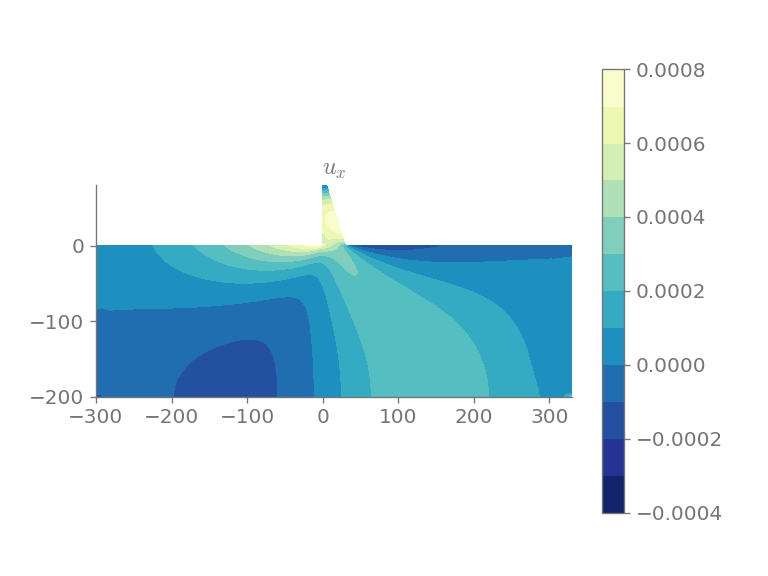

/home/nguarinz/anaconda3/lib/python3.6/site-packages/solidspy/postprocesor.py:108: UserWarning: The following kwargs were not used by contour: 'shading'
  disp_plot(tri, field, levels, shading="gouraud")


<IPython.core.display.Javascript object>


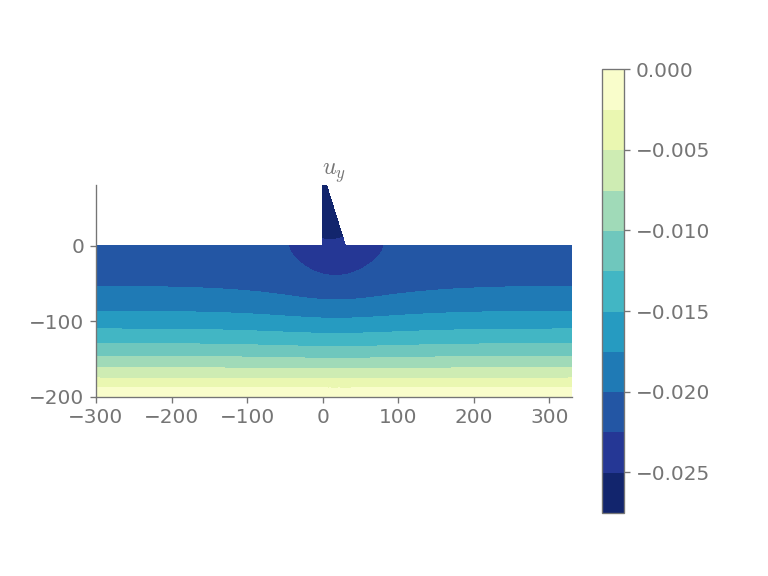

<IPython.core.display.Javascript object>


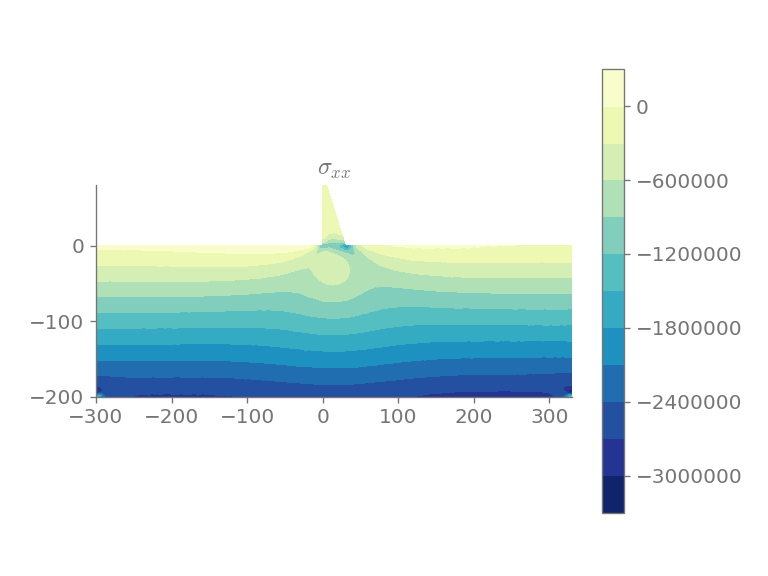

<IPython.core.display.Javascript object>


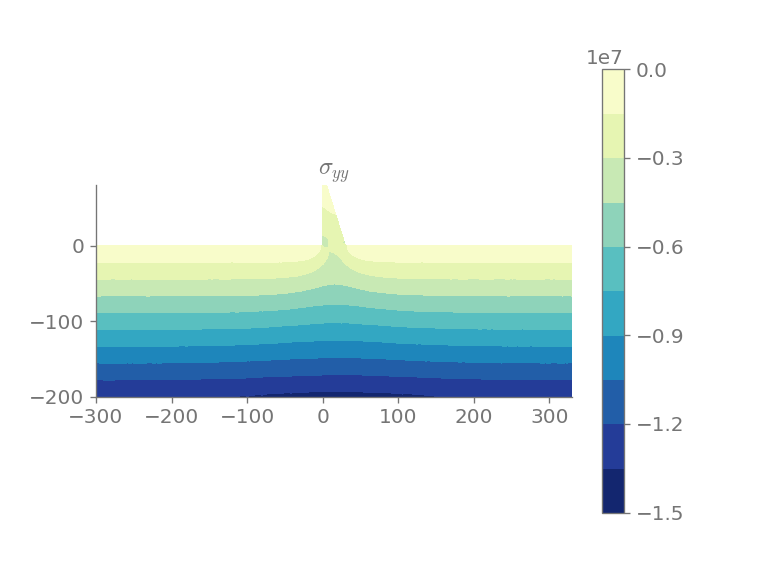

<IPython.core.display.Javascript object>


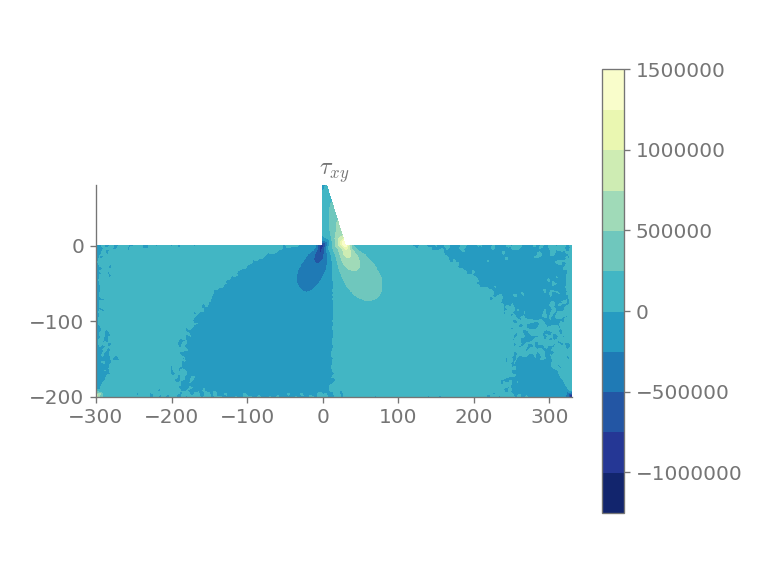

In [13]:
E_nodes, S_nodes = pos.strain_nodes(nodes, elements, mats, UC)
pos.fields_plot(elements, nodes, UC, S_nodes=S_nodes)

### Tensiones principales

Las tensiones principales se calculan de acuerdo con

$$\sigma^{\max,\, \min} = \tau_{\max}\pm\sigma_c$$

donde el cortante máximo $\tau_{\max}$ está dado por:

$$\tau_{\max}^2 = \left(\frac{\sigma_x - \sigma_y}{2}\right)^2 + \tau_{xy}^2$$

y la componente hidrostática del tensor es

$$\sigma_c = \frac{\sigma_x + \sigma_y}{2}.$$


In [14]:
eigs1, eigs2, vecs1, vecs2 = pos.principal_dirs(S_nodes)
TAO = np.abs(eigs1 - eigs2)

### $\sigma^1$

<IPython.core.display.Javascript object>


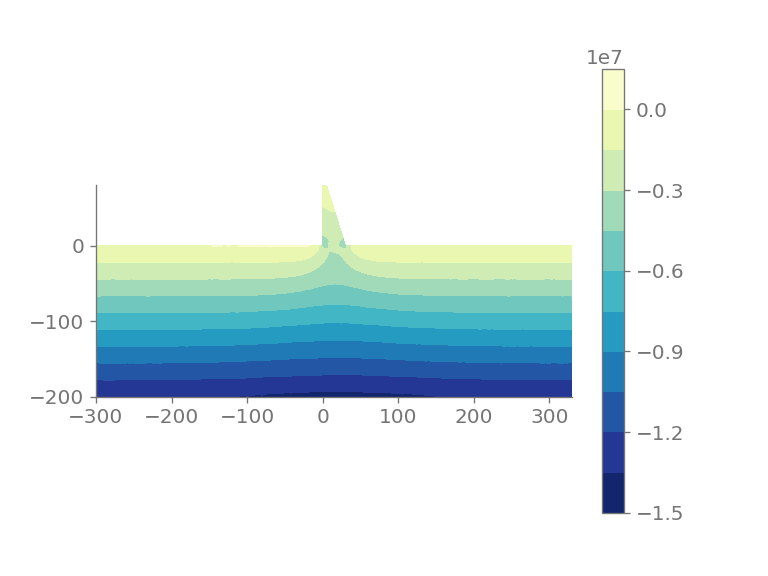

In [15]:
pos.plot_node_field(eigs1, nodes, elements, plt_type="contourf", levels=12)

<IPython.core.display.Javascript object>


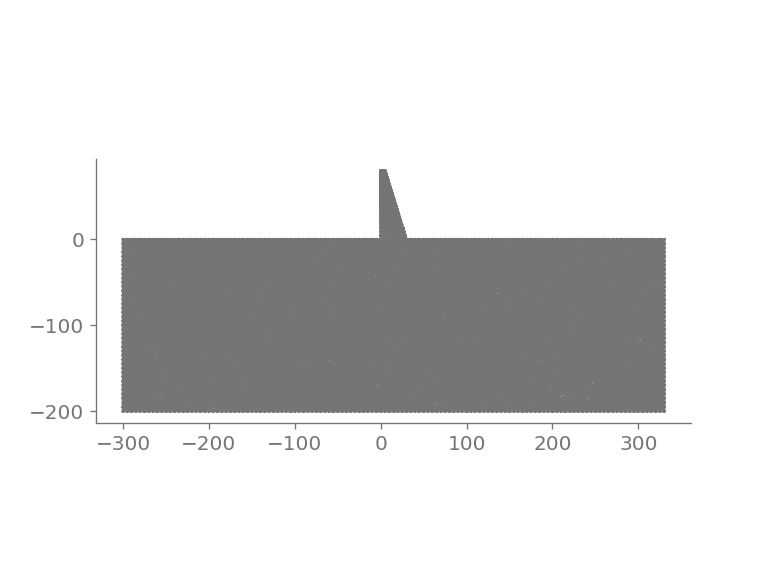

In [16]:
filtered(nodes, elements, eigs1, -6.0e7)

### $\sigma^2$

<IPython.core.display.Javascript object>


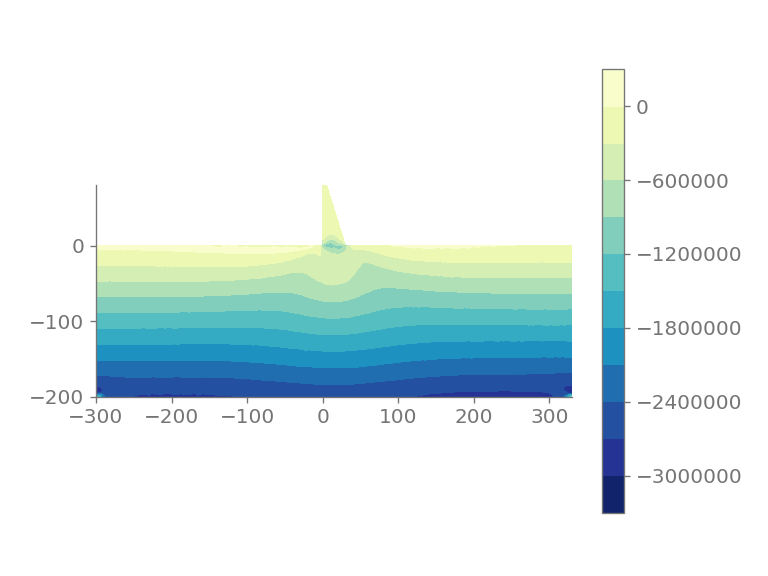

In [17]:
pos.plot_node_field(eigs2, nodes, elements, plt_type="contourf", levels=12)

<IPython.core.display.Javascript object>


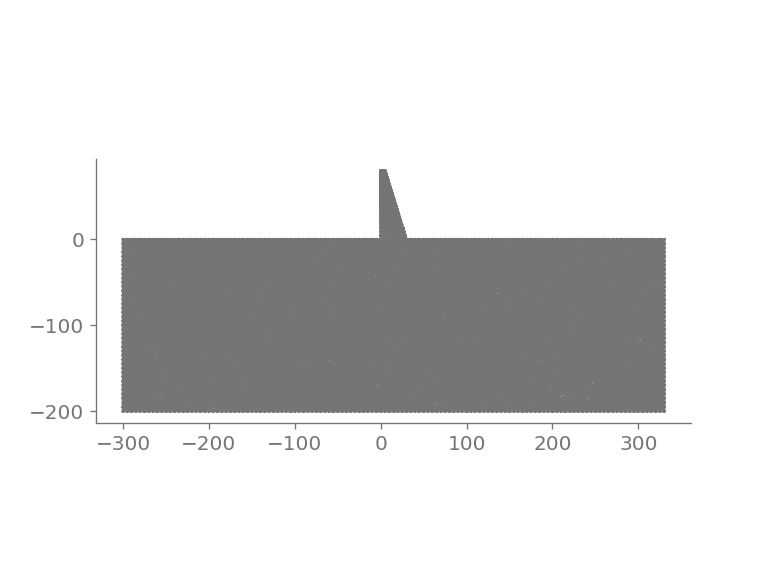

In [18]:
filtered(nodes, elements, eigs2, 1.0e7)

### $\tau^{\max}$

<IPython.core.display.Javascript object>


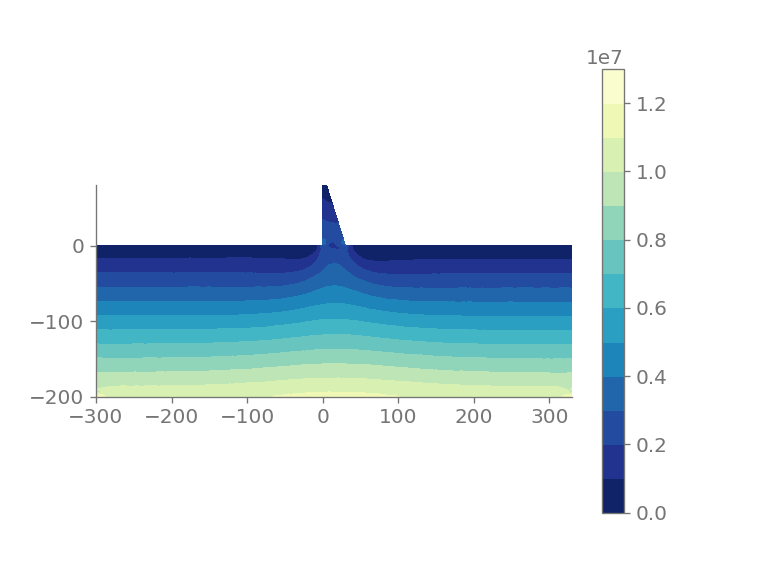

In [19]:
pos.plot_node_field(TAO, nodes, elements, plt_type="contourf", levels=12)

<IPython.core.display.Javascript object>


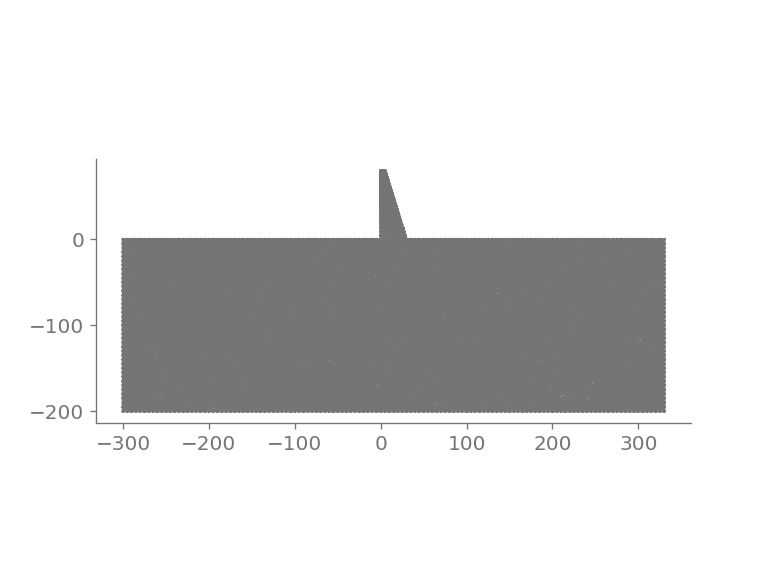

In [20]:
filtered(nodes, elements, TAO, 1.5e7)

## Algunas unidades y equivalencias útiles

* $1 \quad \text{ N} = 1\quad \text{ kg m/s}^2$.

* $1\quad \text{ Pa} = 1 \text{ N/m}^2$.

* $1\quad \text{ kPa} = 1 \times 10^3 \text{ Pa}$.

* $1\quad \text{ MPa} = 1 \times 10^6 \text{ Pa}$.

* $1\quad \text{ GPa} = 1 \times 10^9 \text{ Pa}$.

## Mapa de lineas
El mapa de lineas y de puntos útil para la manipulación del modelo en Gmsh es el siguiente.

<center><img src="img/dam_map.png" alt="files" style="width:500px"></center>

### Referencias

* Juan Gómez, Nicolás Guarín-Zapata (2018). SolidsPy: 2D-Finite Element Analysis with Python, <https://github.com/AppliedMechanics-EAFIT/SolidsPy>.

In [44]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()